# Unit-testing for Response Spectrum Generation Functions
*August 20th 2021*

**Aim - Generate test cases for the response_spectrum functions**
- Generate test case by comparing step-by-step method with fft method using time histories rom test-resources.
- Generate test case based on theoretical solution.
- Generate test case from SHAKE result (for step-by-step method).

In [2]:
# Standard library imports
import os
import sys
from itertools import product, accumulate
from time import perf_counter

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy.lib.recfunctions import structured_to_unstructured
from scipy.signal import resample
from scipy.integrate import cumtrapz, solve_ivp
from scipy.interpolate import interp1d
from numba import jit

# Add project root to path
pkg_path = os.path.abspath("..")
if pkg_path not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))

# Local application imports
import autoRS

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Useful Variables and Functions

In [70]:
# Get closest higher power of 2
def next_pwr_of_2(n):
    """Get the closest higher number that is a power of 2"""
    pwr = np.ceil(np.log(n)/np.log(2))
    return int(2**pwr)

# Hard low-pass filter
def low_pass_filter(signal, lp_frq, dt=0.005, time=None, zero_pad=True):
    """Function to low-pass filter a signal in the frequency domain
    by setting all fourier terms larger than `lp_freq` to 0.
    """
    if time is not None:
        dt = time[1]-time[0]
    if zero_pad:
        n = 2*next_pwr_of_2(len(signal))
    else:
        n = len(signal)
    frq = np.fft.rfftfreq(n, d=dt)
    signal_fft = np.fft.rfft(signal, n=n)
    lp_fft = signal_fft*(frq <= lp_frq)
    lp_signal = np.fft.irfft(lp_fft, n)[:len(signal)]
    return lp_signal

# Up-sample signal
def upsample(signal, time, multiplier):
    """Up-sample the signal. Multiply the number of points by multiplier."""
    num = multiplier*len(signal)
    up_signal = resample(signal, num)
    up_time = np.linspace(min(time), max(time), num=num, endpoint=True)
    return up_signal, up_time

# Numerical Integration
def _dstate_dt(t, state, a_func, fn, zeta):
    wn = fn*2*np.pi
    try:
        a_new = -a_func(t) - 2*zeta*wn*state[1] -(wn**2)*state[0]
    except ValueError:
        print(t)
    dsdt = [state[1], a_new]
    return dsdt

def odesolve_for_x(acc, tm, fn, zeta = 0.05, x0 = 0, v0 = 0, kind='linear'):
    a_func = interp1d(tm, acc, kind='linear')
    t_span = (min(tm), max(tm))
    res = solve_ivp(_dstate_dt, t_span, [x0, v0], args=(a_func, fn, zeta),
                   t_eval=tm)
    return res

## Test case comparing Shake and FFT methods


### Import example time histories

- Import from `multi_col.csv`.
- Remove the last column which is filled with NaNs.
- Up-sample the THs. TH is is done to compare FFT and step methods. The step-by-step method becomes inaccurate if the TH sample rate is not sufficiently greater than the highest frequency content. Up-sampling ensures a fair comparison between the methods for unit-testing purposes.
- Alternative to up-sampling: Low-pass filter the THs at a frequency sufficiently lower than the sample rate to reduce the theoretical inaccuracy of the step-by-step method.

In [4]:
th_path = os.path.join("../tests", "test_resources", "multi_col.csv",)
th_raw = np.genfromtxt(
        th_path,
        delimiter=",",
        skip_header=1,
        names=True,
        deletechars=" !#$%&'()*+,-./:;<=>?[\\]^{|}~",
    )

# Convert to unstructured ndarray and remove nan values (last column)
th_raw = structured_to_unstructured(th_raw)
time = th_raw[:, 0]
th_arr = th_raw[:, 1:-1]

# Get number of THs
num_ths = th_arr.shape[1]
setnums = list(range(1, num_ths+1))

In [84]:
# Get upsampled THs to compare FFT and SHAKE methods
up_th_arr = []
for setnum in setnums:
    up_signal, up_time = upsample(th_arr[:, setnum-1], time, 4)
    up_th_arr.append(up_signal)
up_th_arr = np.array(up_th_arr).T

In [124]:
# Set up colormap
cmap = cm.get_cmap('viridis')
colors = [cmap(x) for x in np.linspace(0, 1, num=num_ths)]

# Pick test damping values
zeta_arr = np.linspace(0.01, 0.8, num=num_ths)

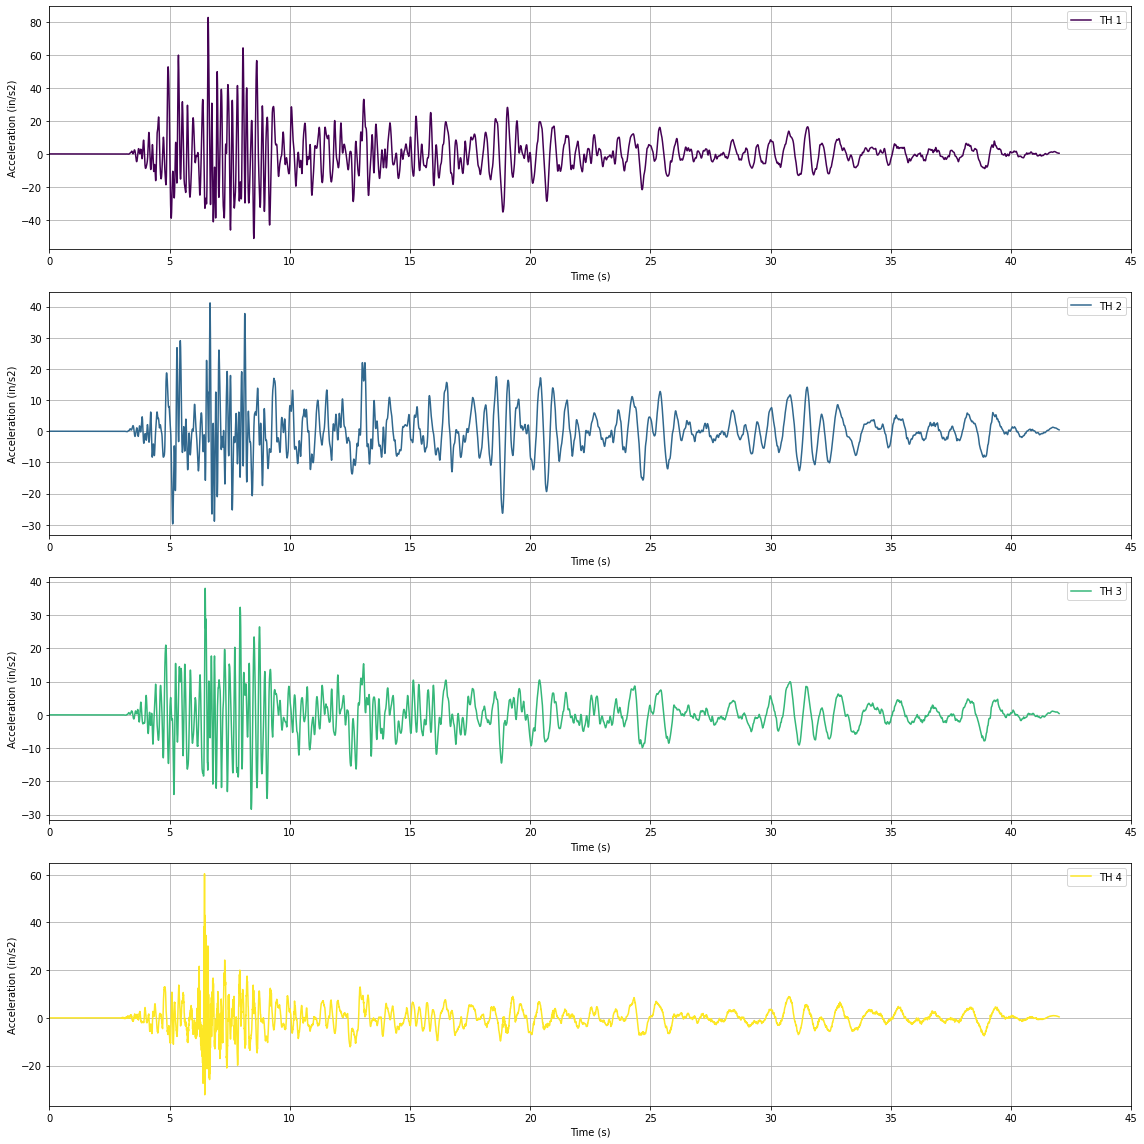

In [98]:
# Plot example THs
fig, axes = plt.subplots(nrows=num_ths, figsize=(16, 4*num_ths))
for setnum, ax, c in zip(setnums, axes, colors):
    ax.plot(time, th_arr[:, setnum-1], color=c, label=f"TH {setnum}")
    ax.grid(which='both')
    ax.legend()
    ax.set(
        xlim=(0, 45),
        xlabel="Time (s)",
        ylabel="Acceleration (in/s2)",
    )
plt.tight_layout()

The Shake and FFT methods should give the same result provided that the time history (TH) sampling frequency is sufficiently greater (>8x) than the highest frequency content. So, when comparing the spectra for unit-tests, low-pass filter the THs first.

Since the example THs have been sampled at 200Hz, the low-pass frequency is taken as 200/8 = 25Hz.

In [94]:
lp_freq = 25

### Generate RS with all methods (low-pass and actual)

In [125]:
rs_dict = {}
lp_rs_dict = {}
for method in autoRS.RS_METHODS:
    rs_dict[method] = [
        autoRS.response_spectrum(
            th_arr[:, i], time, zeta=zeta_arr[i], method=method, high_frequency=False,
        )[0]
        for i in range(num_ths)
    ]
    
    lp_rs_dict[method] = [
        autoRS.response_spectrum(
            low_pass_filter(th_arr[:, i], lp_freq, time=time), 
            time, zeta=zeta_arr[i], method=method, high_frequency=False,
        )[0] 
        for i in range(num_ths)
    ]

frq = autoRS.spectrum.get_default_frequencies(high_frequency=False)

RS done. Time taken = 0.54696s 
time per iteration = 0.00547s
RS done. Time taken = 0.48938s 
time per iteration = 0.00489s
RS done. Time taken = 0.44995s 
time per iteration = 0.00450s
RS done. Time taken = 0.40057s 
time per iteration = 0.00401s
RS done. Time taken = 0.45945s 
time per iteration = 0.00459s
RS done. Time taken = 0.44727s 
time per iteration = 0.00447s
RS done. Time taken = 0.49188s 
time per iteration = 0.00492s
RS done. Time taken = 0.45135s 
time per iteration = 0.00451s
RS done. Time taken = 4.42533s 
time per iteration = 0.04425s
RS done. Time taken = 4.84625s 
time per iteration = 0.04846s
RS done. Time taken = 4.82670s 
time per iteration = 0.04827s
RS done. Time taken = 4.79967s 
time per iteration = 0.04800s
RS done. Time taken = 4.88911s 
time per iteration = 0.04889s
RS done. Time taken = 5.42317s 
time per iteration = 0.05423s
RS done. Time taken = 4.89962s 
time per iteration = 0.04900s
RS done. Time taken = 4.80517s 
time per iteration = 0.04805s


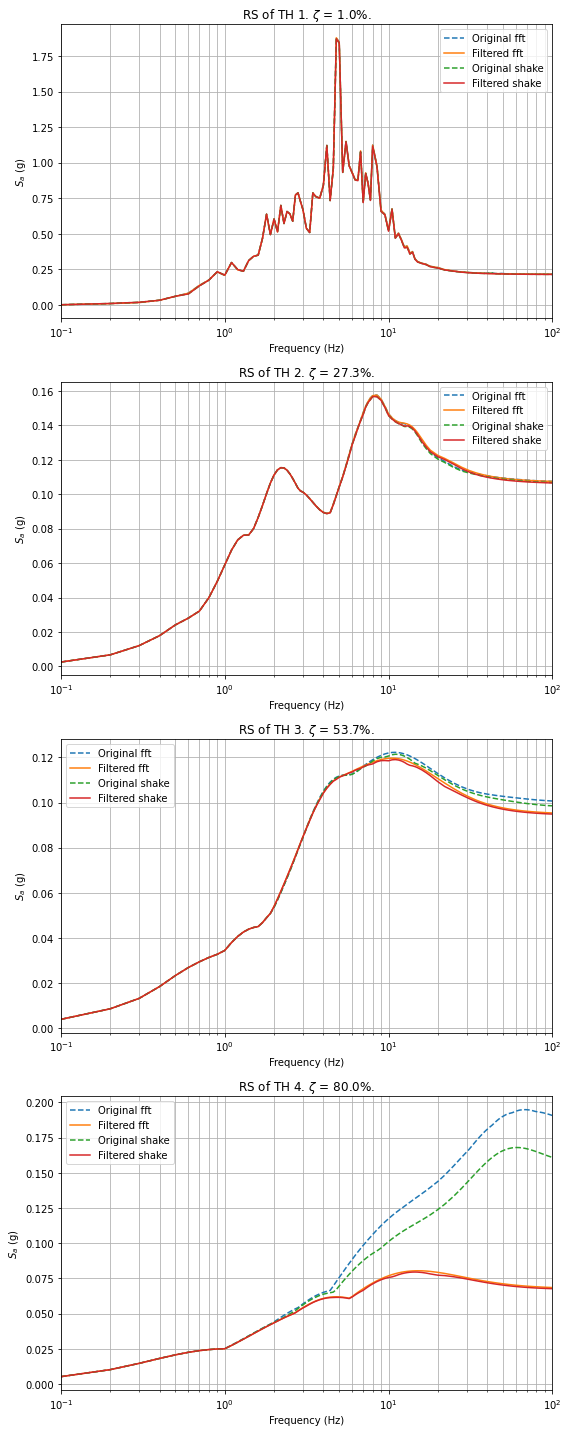

In [141]:
fig, axes = plt.subplots(nrows=num_ths, figsize=(8, 5*num_ths))

for setnum, ax in zip(setnums, axes):
    for method in autoRS.RS_METHODS:
        ax.semilogx(frq, rs_dict[method][setnum-1]/386.1, '--', label=f"Original {method}")
        ax.semilogx(frq, lp_rs_dict[method][setnum-1]/386.1, '-', label=f"Filtered {method}")
    ax.grid(which='both')
    ax.legend()
    _ = ax.set(
        xlim=(min(frq), max(frq)),
        xlabel="Frequency (Hz)",
        ylabel="$S_a$ (g)",
        title=fr"RS of TH {setnum}. $\zeta$ = {zeta_arr[setnum-1]*100:.1f}%.",
    )
plt.tight_layout()

### Possible Unit Tests

1. Ensure max. difference is less than 5%.
2. Ensure mean difference is less than 1%.

In [129]:
max_diffs = [
    np.quantile(np.absolute((lp_rs_dict["fft"][setnum-1]/lp_rs_dict["shake"][setnum-1]) - 1), 0.95)
    for setnum in setnums
]
print(max_diffs)

mean_diffs = [
    np.mean(np.absolute((lp_rs_dict["fft"][setnum-1]/lp_rs_dict["shake"][setnum-1]) - 1))
    for setnum in setnums
]
print(mean_diffs)

[0.023978845538721417, 0.008661309555850505, 0.009590293733734588, 0.018576031833897794]
[0.009826969077825211, 0.004472314229868133, 0.004140007776802941, 0.008597628394259675]


In [130]:
print("1) Results check max: ", all([diff < 0.05 for diff in max_diffs]))
print("2) Results check mean: ", all([diff < 0.01 for diff in mean_diffs]))

1) Results check max:  True
2) Results check mean:  True


## Test case using Theoretical solutions

The theoretical solution for a base-excited spring-mass-damper system is presented in the excellent Brown Univerity Intro to Dynamics and Vibrations [website][1]. Unit tests for the RS algorithms can be implemented with the theoretical solution with various values of $\omega$, $\omega_n$, and $\zeta$.

<img src="_resources/theoretical_soln.png" alt="Theoretical solution of spring-mass-damper motion under sinusoidal base excitation" style="width:700px;" title="Theoretical solution"/>

[1]: https://www.brown.edu/Departments/Engineering/Courses/En4/Notes/vibrations_forced/vibrations_forced.htm

### Theoretical Example

In [222]:
fn = 1.15
wn = fn*2*np.pi

f = 1
w = f*2*np.pi

w_rat = w/wn
print(w_rat)

y_max = 1

zeta_eg = 0.05

t = np.linspace(0, 10, num=int(10*f*1000))
y = y_max*np.sin(w*t)
v_y = w*y_max*np.cos(w*t)
a_y = -w**2*y

0.8695652173913044


In [223]:
def theory_solve_for_x(Y0, w_rat, zeta):
    X0 = Y0*(1 + (2*zeta*w_rat)**2)**0.5 / ((1 - w_rat**2)**2 + (2*zeta*w_rat)**2)**0.5
    phi = np.arctan2((-2*zeta*w_rat**3), (1 - (1 - 4*zeta**2)*w_rat**2))
    return X0, phi

x_max, phi = theory_solve_for_x(y_max, w_rat, zeta)
x = x_max*np.sin(w*t + phi)
v_x = x_max*w*np.cos(w*t + phi)
a_x = -w**2*x
print(x_max)

3.877124538192071


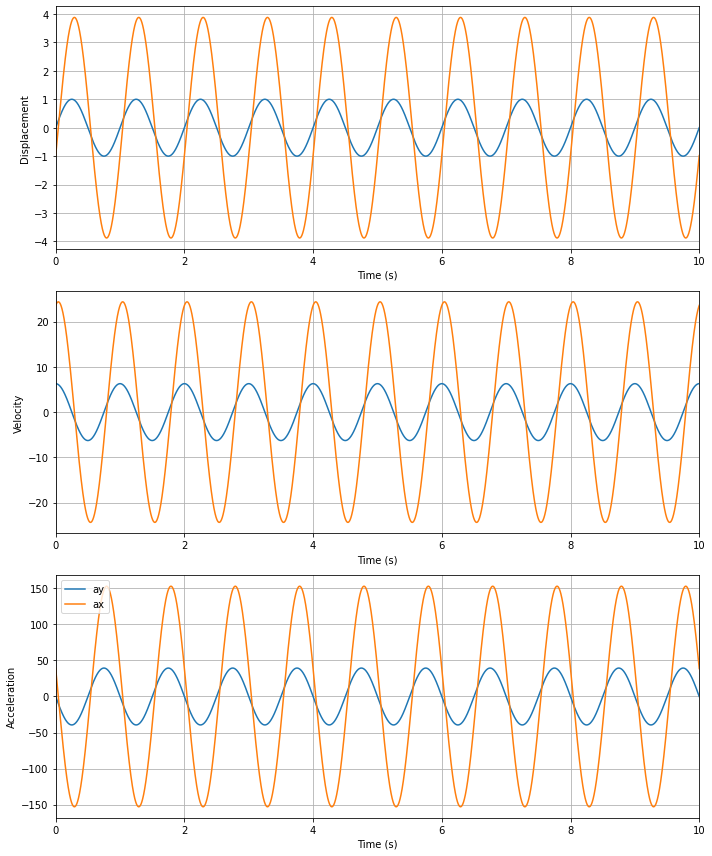

In [224]:
# Plot THs
fig, axes = plt.subplots(nrows=3, figsize=(10, 4*3))
axes[0].plot(t, y, label="y")
axes[0].plot(t, x, label="x")
axes[1].plot(t, v_y, label="vy")
axes[1].plot(t, v_x, label="vx")
axes[2].plot(t, a_y, label="ay")
axes[2].plot(t, a_x, label="ax")

for ylabel, ax in zip(["Displacement", "Velocity", "Acceleration"], axes):
    ax.set_ylabel(ylabel)
    
for ax in axes:
    ax.grid(which='both')
    ax.set(
        xlim=(0, max(t)),
        xlabel="Time (s)",
    )
ax.legend()
plt.tight_layout()

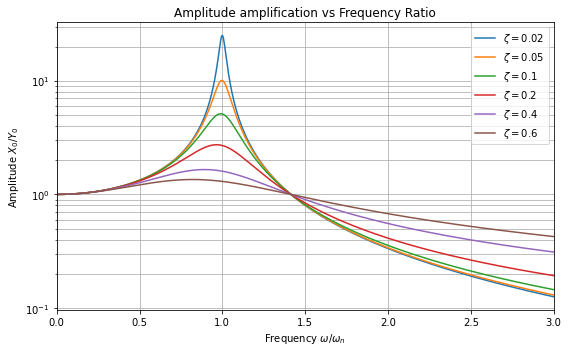

In [225]:
w_rats = np.linspace(0, 3, num=1501)
zetas = [0.02, 0.05, 0.1, 0.2, 0.4, 0.6]
amp_rats = [theory_solve_for_x(1, w_rats, zeta)[0] for zeta in zetas]

# Plot THs
fig, ax = plt.subplots(figsize=(8, 5))
for amp_rat, zeta in zip(amp_rats, zetas):
    ax.semilogy(w_rats, amp_rat, label=f"$\zeta = {zeta}$")
ax.grid(which='both')
ax.set(
    xlim=(0, max(w_rats)),
    xlabel="Frequency $\omega/\omega_n$",
    ylabel="Amplitude $X_0/Y_0$",
    title="Amplitude amplification vs Frequency Ratio",
)
ax.legend()
plt.tight_layout()

**Notes**

- The theoretical solution is periodic. To be able to capture the periodic behaviour the autoRS function implementations need to be modified.
- The Step-by-step method needs to include an optional initial condition argument.
- The FFT method typically zero-pads the input to prevent 'end-effects' when processing seismic time histories. This is to ensure the periodic nature of the fourier transform does not 'contaminate' the time history which is not actually periodic. To be able to match the theoretical solution for periodic motion, the input must NOT be zero-padded. So, an option needs to be added to prevent zero-padding.
- Although the above changes are not required for the typical use-case (seismic time histories), the changes will make the code more modular and testable.

### Recreate with FFT method

In [226]:
print(autoRS.spectrum._fft_rs(a_y, t, [fn], zeta=zeta_eg))
print(autoRS.spectrum._step_rs(a_y, t, [fn], zeta=zeta_eg))

(array([196.08992498]), array([1.15]))
(array([195.52248497]), array([1.15]))


In [227]:
min(a_x)

-153.06274063051663

In [228]:
n = len(a_y)
n_fft = int(2 ** (np.ceil(np.log(1.5 * n) / np.log(2))))

In [229]:
xgfft = np.fft.rfft(a_y, n=n)
frqt = np.fft.rfftfreq(n, d=t[1]-t[0])

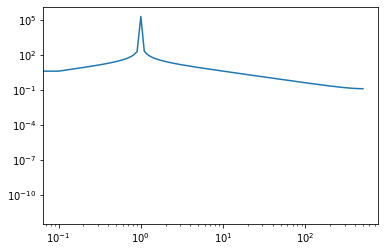

In [230]:
plt.loglog(frqt, np.absolute(xgfft))

In [231]:
wf = frqt*2*np.pi
wn = fn*2*np.pi
zeta = zeta_eg
multiplier = 8

t_multi = np.linspace(min(t), max(t), num=n*multiplier)


timing_0 = perf_counter()

xfft = -xgfft / (-(wf ** 2) + 2 * zeta * wn * 1j * wf + wn ** 2)

# Relative acceleration of spring mass (fourier terms)
accfft = -xfft * wf ** 2

# Absolute acceleration of spring mass (fourier terms)
abs_accfft = accfft + xgfft


# Get absolute acceleration of spring mass (time domain)
# Up-sample so that the final time history is sinc-
# interpolated with `n_multiplier` total points
a = np.fft.irfft(abs_accfft, n=multiplier * n) * multiplier
# a[0] = 0
abs_xfft = xfft
abs_xfft[1:] = abs_xfft[1:] + xgfft[1:]/(-wf[1:]**2)
abs_vfft = abs_xfft*wf*1j
# v = cumtrapz(a, x=t_multi, initial=0)
# s = cumtrapz(v, x=t_multi, initial=0)

v = np.fft.irfft(abs_vfft, n=multiplier * n) * multiplier
s = np.fft.irfft(abs_xfft, n=multiplier * n) * multiplier

timing_1 = perf_counter()
print(timing_1 - timing_0)

0.008435899999312824


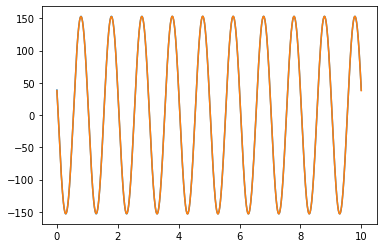

In [232]:
plt.plot(t, a_x)
plt.plot(t_multi, a)

In [233]:
print(max(a))
print(max(a_x))

153.22404807023673
153.06273855176278


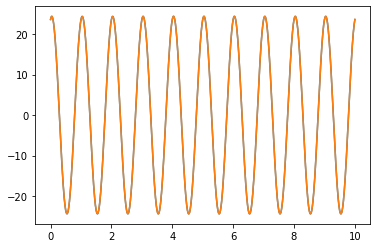

In [234]:
plt.plot(t, v_x)
plt.plot(t_multi, v)

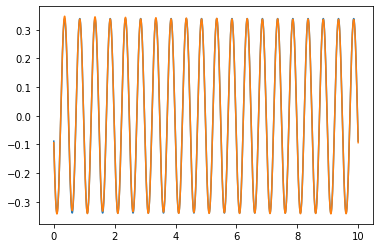

In [177]:
plt.plot(t, x)
plt.plot(t_multi, s)

In [178]:
test_y = np.fft.irfft(xgfft, n=n)

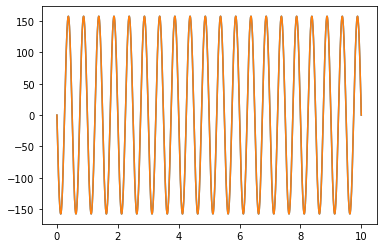

In [179]:
plt.plot(t, a_y)
plt.plot(t, test_y)

### Recreate with Step-by-step method

In [150]:
def custom_step_rs(
    acc, time, frq, zeta: float = 0.05, x0 = 0, v0 = 0,
) -> [np.ndarray, np.ndarray]:
    

    # Instantiate angular frequency and spectral acceleration arrays
    wn = frq * 2 * np.pi
    rs = 0 * w

    # Define timestep from input signal
    dt = time[1] - time[0]

    timing_0 = perf_counter()

    # Calculate response acceleration time history
    A, B = autoRS.spectrum._get_step_matrix(wn, zeta, dt)

    # Define utility function to be used with itertools.accumulate
    def func(x_i, a_i) -> np.ndarray:
        return np.dot(A, x_i) + np.dot(B, a_i)

    act = np.column_stack((acc[:-1], acc[1:]))
#     act = np.append(np.array([[0, acc[0]]]), act, axis=0)
    print(act[0])
    x = np.array(list(accumulate(act, func, initial=np.array([x0, v0]).T)))
    temp = -np.array([wn ** 2, 2 * zeta * wn])
    z = np.dot(x, temp)
    
    timing_1 = perf_counter()
    print(timing_1 - timing_0)

    return z, x[:, 0]

In [180]:
zeta = zeta_eg
x0 = x[0] - y[0]
v0 = v_x[0] - v_y[0]
a_step, x_step = custom_step_rs(a_y, t, fn, zeta=zeta, x0=x0, v0=v0)

[-0.         -0.99224394]
0.2644354000003659


In [181]:
zeta = zeta_eg
x0 = x[0] - y[0]
v0 = v_x[0] - v_y[0]
res = odesolve_for_x(a_y, t, fn, zeta=zeta, x0=x0, v0=v0)

In [182]:
res_x = res['y'][0, :]
res_v = res['y'][1, :]
res_a = np.gradient(res_v, t) + a_y

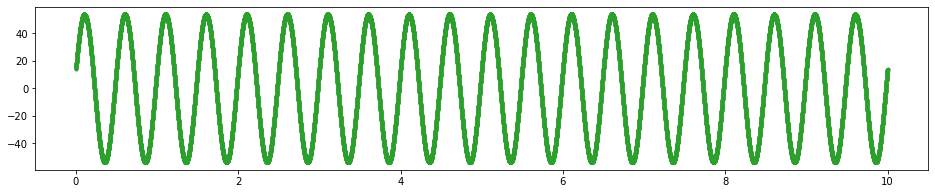

In [189]:
plt.figure(figsize=(16, 3))
plt.plot(t, a_x)
plt.plot(t, a_step, '-')
plt.plot(t, res_a, '-')

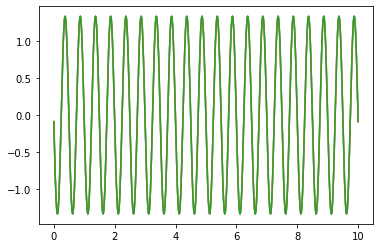

In [184]:
plt.plot(t, x-y)
plt.plot(t, x_step)
plt.plot(t, res_x)